In [11]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import julian
from datetime import datetime
from pygplib3 import landfall as ld
from past.utils import old_div
import cartopy.crs as ccrs
from tcrisk.hazard import windfield
from chaz.utility import knaff15
import cartopy.feature as cfeature

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.rcParams.update({'font.size': 12})

In [ ]:
# Root directory: change to where data downloaded to
root_dir = '/data2/jbaldwin/WCAS2023'

# Load IBTRACs data

In [13]:
dat = xr.open_dataset(root_dir+'/HAZARD/TC_TRACKS/IBTrACS/ibtracsv04r00_landfall_philippines.nc')
lon = np.array(dat.lon)
lat = np.array(dat.lat)
wspd = np.array(dat.wspd)/1.944 #convert from kts to m/s
days = np.array(dat.days)
year = np.array(dat.year)

In [14]:
# Calculate track angle and track translation speed 
er = 6371.0  # earth's radius; km
lon_diff = lon[1:, :]-lon[0:-1, :]
lat_diff = lat[1:, :]-lat[0:-1, :]
londis = old_div(2*np.pi*er*np.cos(old_div(lat[1:, :],180)*np.pi),360) # longitude distance at a latitude; km
dx = londis*1000*lon_diff # meters
dy = 110.*1000*lat_diff # meters
time_diff = (days[1:, :] - days[0:-1, :])*24.*60*60 # seconds
tr = old_div(np.sqrt(dx**2+dy**2),(time_diff)) # track translation speed
trDir = np.arctan2(lat_diff, lon_diff) # track angle
# note: subtraction cuts off point at end, might need to add one final track direction and speed point if get errors later

In [15]:
# Interpolate to 15-min timesteps
nscale = 24 # convert from 6-hr to 15-min timesteps (factor of 6*4=24)
lon = ld.rescale_matrix(lon,nscale,0) # int for time interpolated 
lat = ld.rescale_matrix(lat,nscale,0)
wspd = ld.rescale_matrix(wspd,nscale,0)
days = ld.rescale_matrix(days,nscale,0)
tr = ld.rescale_matrix(tr,nscale,0)
trDir = ld.rescale_matrix(trDir,nscale,0)

In [16]:
# Convert modified Julian days to date-time objects
nmax = np.shape(days)[1]
imax = np.shape(days)[0]
dt = np.full([nmax, imax], np.nan, dtype='datetime64[s]')
month = np.full([nmax, imax], np.nan)
day = np.full([nmax, imax], np.nan)
for n in range(nmax):
    mjd = days[:,n]
    for i in np.where(~np.isnan(mjd))[0]:
        x = julian.from_jd(mjd[i], fmt='mjd')
        dt[n,i] = x
        month[n,i] = int(x.date().month)
        day[n,i] = int(x.date().day)
year = dat.year.values
    

# Convert to datetime format
dt2 = []
for i in range(len(dt)):
    dt2.append(dt[i][0].astype(datetime))

# Calculate TC start and end dates
tc_start_date = np.min(dt,axis=1)
tc_end_date = np.max(dt,axis=1)

# Calculate duration of years
dyear = dt2[-1].year-dt2[0].year

In [17]:
# Bounding box for the Philippines
lonmin = 117.17427453
latmin = 5.58100332277
lonmax = 126.537423944
latmax = 18.5052273625

In [39]:
# Location of SAR data
direc_sar = root_dir+'/HAZARD/WIND_SWATHS/SAR/'

# Define function for producing wind field at one point over domain of SAR data

def wspdmap_sar(ds_sar,nS,iT):
    # Define x-y grid to put profile on
    lonmin = float(ds_sar.longitude.min().values)
    lonmax = float(ds_sar.longitude.max().values)
    latmin = float(ds_sar.latitude.min().values)
    latmax = float(ds_sar.latitude.max().values)
    buffer = 1
    X = np.arange(lonmin-buffer,lonmax+buffer,0.1) #Philippines lon rounded to nearest whole degree (down for min, up for max), plus 0.5deg further for wind radius
    Y = np.arange(latmin-buffer,latmax+buffer,0.1) #Philippines lon rounded to nearest whole degree (down for min, up for max), plus 0.5deg further for wind radius
    X1, Y1 = np.meshgrid(X,Y)
    
    # Load relevant data from ibtracs
    lon_nS = lon[:,nS]
    lat_nS = lat[:,nS]
    wspd_nS = wspd[:,nS]
    tr_nS = tr[:,nS]
    trDir_nS = trDir[:,nS]
    rmax_nS = knaff15(wspd_nS*1.944, lat_nS)  #  wspd should be input in kts, outputs in km
    rmax_min = 20 # km
    rmax_nS[np.where(rmax_nS<rmax_min)] = rmax_min # 6-12-20: set places with radii less than 0 to 20 km to fix convergence
    
    # Calculate windfield
    wspdmap = windfield(X1, Y1, lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,iT)
    wspdmap = np.abs(wspdmap)
    
    return wspdmap, X1, Y1, lonmin, lonmax, latmin, latmax


# Molave 2020
* https://www.star.nesdis.noaa.gov/socd/mecb/sar/AKDEMO_products/APL_winds/tropical/?year=2020&storm=WP212020_MOLAVE
* nS = 478
* https://en.wikipedia.org/wiki/Typhoon_Molave

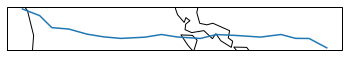

In [179]:
nS = 478
ax = plt.axes(projection=ccrs.PlateCarree())
plt.plot(lon[:,nS],lat[:,nS])
ax.coastlines()
#ax.set_extent([lonmin,lonmax,latmin,latmax])

Text(0.5, 1.0, 'Molave 2020')

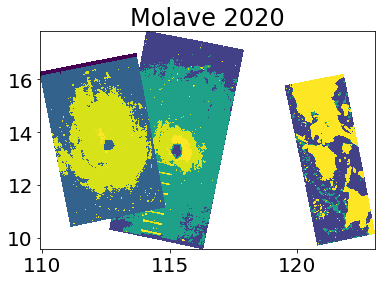

In [26]:
#plt.figure(figsize=(6,5))

vmin = 0
vmax = 40

plt.subplot(111)

file_sar = 'WP212020_MOLAVE/S1B_ESA_2020_10_25_10_05_59_0656935559_121.33E_12.97N_VH_C-7_MERGED04_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
plt.contourf(ds_sar.longitude,ds_sar.latitude,ds_sar.sar_wind,vmin=vmin,vmax=vmax)

direc_sar = '/data2/qy2216/SAR_wind/raw_data/'
file_sar = 'WP212020_MOLAVE/S1A_ESA_2020_10_26_22_12_06_0657065526_115.24E_13.72N_VH_C-7_MERGED02_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
plt.contourf(ds_sar.longitude,ds_sar.latitude,ds_sar.sar_wind,vmin=vmin,vmax=vmax)

file_sar = 'WP212020_MOLAVE/S1A_ESA_2020_10_27_10_39_57_0657110397_112.38E_13.72N_VH_C-7_MERGED02_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
plt.contourf(ds_sar.longitude,ds_sar.latitude,ds_sar.sar_wind,vmin=vmin,vmax=vmax)

plt.title('Molave 2020')

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less


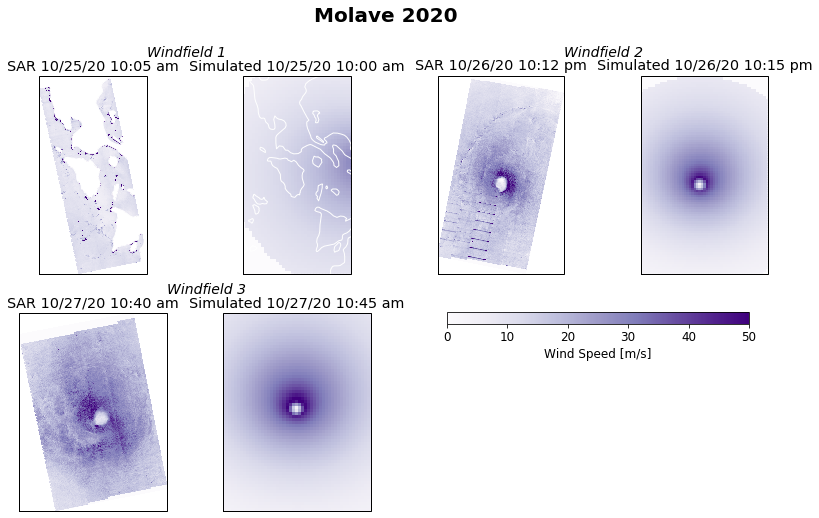

In [56]:
fig = plt.figure(figsize=(14,8))
plt.suptitle('Molave 2020',y=1,fontweight='bold',fontsize=20)
nS = 478
vmin = 0
vmax = 50
cmap = plt.cm.Purples

# Timestep 1
iT = np.where(dt[nS,:]==np.datetime64('2020-10-25T10:00:00'))[0][0]
file_sar = 'WP212020_MOLAVE/S1B_ESA_2020_10_25_10_05_59_0656935559_121.33E_12.97N_VH_C-7_MERGED04_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
wspdmap, X1, Y1, lonmin, lonmax, latmin, latmax = wspdmap_sar(ds_sar,nS,iT)

ax = plt.subplot(241,projection=ccrs.PlateCarree())
sar_wind = xr.where(ds_sar.sar_wind==100,np.nan,ds_sar.sar_wind)
plt.pcolormesh(ds_sar.longitude,ds_sar.latitude,sar_wind,vmin=vmin,vmax=vmax,transform =ccrs.PlateCarree(),cmap=cmap)
ax.add_feature(land_50m,zorder = 1,color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('SAR 10/25/20 10:05 am')
ax.text(1, 1.1, 'Windfield 1', fontsize=14,transform=ax.transAxes,horizontalalignment='left',style='italic')

ax = plt.subplot(242,projection=ccrs.PlateCarree())
p = plt.pcolormesh(X1,Y1,wspdmap,vmin=vmin,vmax=vmax, transform =ccrs.PlateCarree(),cmap=cmap)
ax.coastlines('50m',color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('Simulated 10/25/20 10:00 am')

# Timestep 2
iT = np.where(dt[nS,:]==np.datetime64('2020-10-26T22:15:00'))[0][0]
file_sar = 'WP212020_MOLAVE/S1A_ESA_2020_10_26_22_12_06_0657065526_115.24E_13.72N_VH_C-7_MERGED02_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
wspdmap, X1, Y1, lonmin, lonmax, latmin, latmax = wspdmap_sar(ds_sar,nS,iT)

ax = plt.subplot(243,projection=ccrs.PlateCarree())
sar_wind = xr.where(ds_sar.sar_wind==100,np.nan,ds_sar.sar_wind)
plt.pcolormesh(ds_sar.longitude,ds_sar.latitude,sar_wind,vmin=vmin,vmax=vmax,transform =ccrs.PlateCarree(),cmap=cmap)
ax.add_feature(land_50m,zorder = 1,color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('SAR 10/26/20 10:12 pm')
ax.text(1, 1.1, 'Windfield 2', fontsize=14,transform=ax.transAxes,horizontalalignment='left',style='italic')

ax = plt.subplot(244,projection=ccrs.PlateCarree())
p = plt.pcolormesh(X1,Y1,wspdmap,vmin=vmin,vmax=vmax, transform =ccrs.PlateCarree(),cmap=cmap)
ax.coastlines('50m',color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('Simulated 10/26/20 10:15 pm')

# Timestep 3
iT = np.where(dt[nS,:]==np.datetime64('2020-10-27T10:45:00'))[0][0]
file_sar = 'WP212020_MOLAVE/S1A_ESA_2020_10_27_10_39_57_0657110397_112.38E_13.72N_VH_C-7_MERGED02_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
wspdmap, X1, Y1, lonmin, lonmax, latmin, latmax = wspdmap_sar(ds_sar,nS,iT)

ax = plt.subplot(245,projection=ccrs.PlateCarree())
sar_wind = xr.where(ds_sar.sar_wind==100,np.nan,ds_sar.sar_wind)
plt.pcolormesh(ds_sar.longitude,ds_sar.latitude,sar_wind,vmin=vmin,vmax=vmax,transform =ccrs.PlateCarree(),cmap=cmap)
ax.add_feature(land_50m,zorder = 1,color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('SAR 10/27/20 10:40 am')
ax.text(1, 1.1, 'Windfield 3', fontsize=14,transform=ax.transAxes,horizontalalignment='left',style='italic')

ax = plt.subplot(246,projection=ccrs.PlateCarree())
p = plt.pcolormesh(X1,Y1,wspdmap,vmin=vmin,vmax=vmax, transform =ccrs.PlateCarree(),cmap=cmap)
ax.coastlines('50m',color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('Simulated 10/27/20 10:45 am')

# COLORBAR FOR LOSSES
cbar_ax = fig.add_axes([0.56, 0.45, 0.3, 0.02]) # x pos, y pos, x width, y width
cb = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cb.set_label(label='Wind Speed [m/s]')

plt.savefig(root_dir+'/FIGURES/windfield_validation_mojave2020.png',dpi=600)

# Goni 2020
* https://www.star.nesdis.noaa.gov/socd/mecb/sar/AKDEMO_products/APL_winds/tropical/?year=2020&storm=WP222020_GONI
* nS = 479
* https://en.wikipedia.org/wiki/Typhoon_Goni

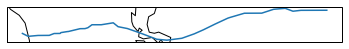

In [15]:
nS = 479
ax = plt.axes(projection=ccrs.PlateCarree())
plt.plot(lon[:,nS],lat[:,nS])
ax.coastlines()
#ax.set_extent([lonmin,lonmax,latmin,latmax])

Text(0.5, 1.0, 'Goni 2020')

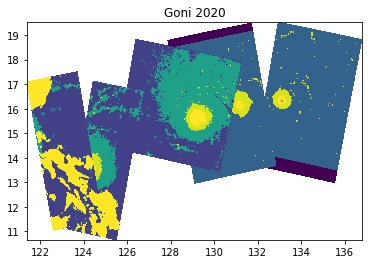

In [16]:
#plt.figure(figsize=(15,10))

vmin = 0
vmax = 40

plt.subplot(111)
direc_sar = '/data2/qy2216/SAR_wind/raw_data/'
file_sar = 'WP222020_GONI/S1A_ESA_2020_10_29_20_57_25_0657320245_134.27E_16.27N_VH_C-7_MERGED02_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
plt.contourf(ds_sar.longitude,ds_sar.latitude,ds_sar.sar_wind,vmin=vmin,vmax=vmax)

file_sar = 'WP222020_GONI/S1A_ESA_2020_10_30_09_26_35_0657365195_130.38E_16.24N_VH_C-7_MERGED02_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
plt.contourf(ds_sar.longitude,ds_sar.latitude,ds_sar.sar_wind,vmin=vmin,vmax=vmax)

file_sar = 'WP222020_GONI/RSAT2_GSS_2020_10_30_21_16_42_0657407802_128.35E_16.14N_VH_C-7_MERGED01_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
plt.contourf(ds_sar.longitude,ds_sar.latitude,ds_sar.sar_wind,vmin=vmin,vmax=vmax)

file_sar = 'WP222020_GONI/S1B_ESA_2020_10_31_21_30_12_0657495012_124.98E_13.90N_VH_C-7_MERGED04_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
plt.contourf(ds_sar.longitude,ds_sar.latitude,ds_sar.sar_wind,vmin=vmin,vmax=vmax)

file_sar = 'WP222020_GONI/S1B_ESA_2020_11_01_09_58_07_0657539887_123.14E_14.28N_VH_C-7_MERGED04_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
plt.contourf(ds_sar.longitude,ds_sar.latitude,ds_sar.sar_wind,vmin=vmin,vmax=vmax)

plt.title('Goni 2020')

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less


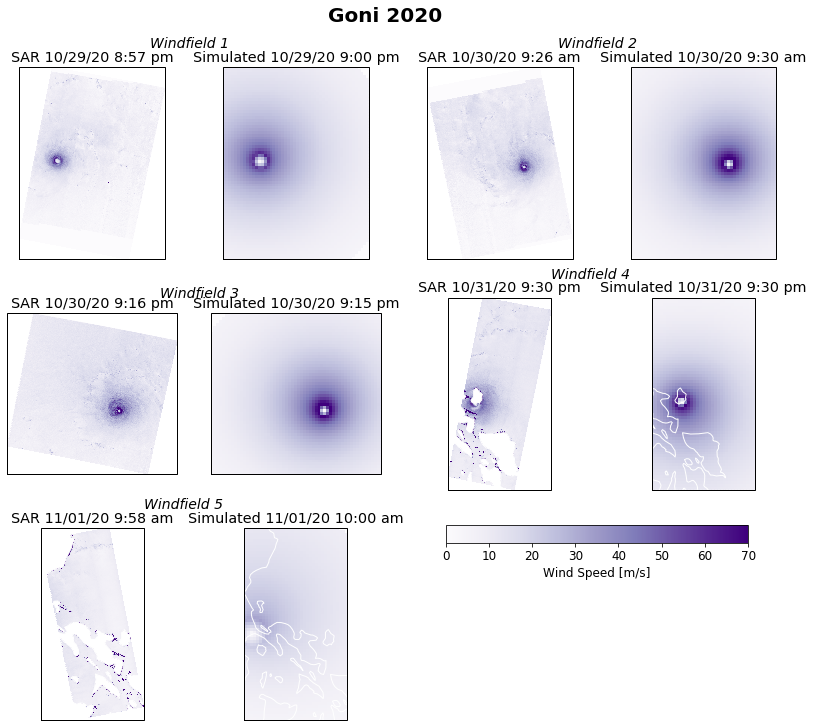

In [57]:
fig = plt.figure(figsize=(14,12))
plt.suptitle('Goni 2020',y=0.95,fontweight='bold',fontsize=20)
vmin = 0
vmax = 70
nS = 479
cmap = plt.cm.Purples

# TIMESTEP 1
iT = np.where(dt[nS,:]==np.datetime64('2020-10-29T21:00:00'))[0][0]
file_sar = 'WP222020_GONI/S1A_ESA_2020_10_29_20_57_25_0657320245_134.27E_16.27N_VH_C-7_MERGED02_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
wspdmap, X1, Y1, lonmin, lonmax, latmin, latmax = wspdmap_sar(ds_sar,nS,iT)

ax = plt.subplot(341,projection=ccrs.PlateCarree())
sar_wind = xr.where(ds_sar.sar_wind==100,np.nan,ds_sar.sar_wind)
plt.pcolormesh(ds_sar.longitude,ds_sar.latitude,sar_wind,vmin=vmin,vmax=vmax,transform =ccrs.PlateCarree(),cmap = cmap)
ax.add_feature(land_50m,zorder = 1,color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('SAR 10/29/20 8:57 pm')
ax.text(0.9, 1.1, 'Windfield 1', fontsize=14,transform=ax.transAxes,horizontalalignment='left',style='italic')

ax = plt.subplot(342,projection=ccrs.PlateCarree())
plt.pcolormesh(X1,Y1,wspdmap,vmin=vmin,vmax=vmax, transform =ccrs.PlateCarree(),cmap = cmap)
ax.coastlines('50m',color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('Simulated 10/29/20 9:00 pm')

# TIMESTEP 2
iT = np.where(dt[nS,:]==np.datetime64('2020-10-30T09:30:00'))[0][0]
file_sar = 'WP222020_GONI/S1A_ESA_2020_10_30_09_26_35_0657365195_130.38E_16.24N_VH_C-7_MERGED02_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
wspdmap, X1, Y1, lonmin, lonmax, latmin, latmax = wspdmap_sar(ds_sar,nS,iT)

ax = plt.subplot(343,projection=ccrs.PlateCarree())
sar_wind = xr.where(ds_sar.sar_wind==100,np.nan,ds_sar.sar_wind)
plt.pcolormesh(ds_sar.longitude,ds_sar.latitude,sar_wind,vmin=vmin,vmax=vmax,transform =ccrs.PlateCarree(),cmap = cmap)
ax.add_feature(land_50m,zorder = 1,color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('SAR 10/30/20 9:26 am')
ax.text(0.9, 1.1, 'Windfield 2', fontsize=14,transform=ax.transAxes,horizontalalignment='left',style='italic')

ax = plt.subplot(344,projection=ccrs.PlateCarree())
plt.pcolormesh(X1,Y1,wspdmap,vmin=vmin,vmax=vmax, transform =ccrs.PlateCarree(),cmap = cmap)
ax.coastlines('50m',color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('Simulated 10/30/20 9:30 am')

# TIMESTEP 3
iT = np.where(dt[nS,:]==np.datetime64('2020-10-30T21:15:00'))[0][0]
file_sar = 'WP222020_GONI/RSAT2_GSS_2020_10_30_21_16_42_0657407802_128.35E_16.14N_VH_C-7_MERGED01_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
wspdmap, X1, Y1, lonmin, lonmax, latmin, latmax = wspdmap_sar(ds_sar,nS,iT)

ax = plt.subplot(345,projection=ccrs.PlateCarree())
sar_wind = xr.where(ds_sar.sar_wind==100,np.nan,ds_sar.sar_wind)
plt.pcolormesh(ds_sar.longitude,ds_sar.latitude,sar_wind,vmin=vmin,vmax=vmax,transform =ccrs.PlateCarree(),cmap = cmap)
ax.add_feature(land_50m,zorder = 1,color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('SAR 10/30/20 9:16 pm')
ax.text(0.9, 1.1, 'Windfield 3', fontsize=14,transform=ax.transAxes,horizontalalignment='left',style='italic')

ax = plt.subplot(346,projection=ccrs.PlateCarree())
plt.pcolormesh(X1,Y1,wspdmap,vmin=vmin,vmax=vmax, transform =ccrs.PlateCarree(),cmap = cmap)
ax.coastlines('50m',color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('Simulated 10/30/20 9:15 pm')

# TIMESTEP 4
iT = np.where(dt[nS,:]==np.datetime64('2020-10-31T21:30:00'))[0][0]
file_sar = 'WP222020_GONI/S1B_ESA_2020_10_31_21_30_12_0657495012_124.98E_13.90N_VH_C-7_MERGED04_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
wspdmap, X1, Y1, lonmin, lonmax, latmin, latmax = wspdmap_sar(ds_sar,nS,iT)

ax = plt.subplot(347,projection=ccrs.PlateCarree())
sar_wind = xr.where(ds_sar.sar_wind==100,np.nan,ds_sar.sar_wind)
plt.pcolormesh(ds_sar.longitude,ds_sar.latitude,sar_wind,vmin=vmin,vmax=vmax,transform =ccrs.PlateCarree(),cmap = cmap)
ax.add_feature(land_50m,zorder = 1,color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('SAR 10/31/20 9:30 pm')
ax.text(1, 1.1, 'Windfield 4', fontsize=14,transform=ax.transAxes,horizontalalignment='left',style='italic')

ax = plt.subplot(348,projection=ccrs.PlateCarree())
plt.pcolormesh(X1,Y1,wspdmap,vmin=vmin,vmax=vmax, transform =ccrs.PlateCarree(),cmap = cmap)
ax.coastlines('50m',color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('Simulated 10/31/20 9:30 pm')

# TIMESTEP 5
iT = np.where(dt[nS,:]==np.datetime64('2020-11-01T10:00:00'))[0][0]
file_sar = 'WP222020_GONI/S1B_ESA_2020_11_01_09_58_07_0657539887_123.14E_14.28N_VH_C-7_MERGED04_wind_level2.nc'
ds_sar = xr.open_dataset(direc_sar+file_sar)
wspdmap, X1, Y1, lonmin, lonmax, latmin, latmax = wspdmap_sar(ds_sar,nS,iT)

ax = plt.subplot(349,projection=ccrs.PlateCarree())
sar_wind = xr.where(ds_sar.sar_wind==100,np.nan,ds_sar.sar_wind)
plt.pcolormesh(ds_sar.longitude,ds_sar.latitude,sar_wind,vmin=vmin,vmax=vmax,transform =ccrs.PlateCarree(),cmap = cmap)
ax.add_feature(land_50m,zorder = 1,color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('SAR 11/01/20 9:58 am')
ax.text(1, 1.1, 'Windfield 5', fontsize=14,transform=ax.transAxes,horizontalalignment='left',style='italic')

ax = plt.subplot(3,4,10,projection=ccrs.PlateCarree())
p = plt.pcolormesh(X1,Y1,wspdmap,vmin=vmin,vmax=vmax, transform =ccrs.PlateCarree(),cmap = cmap)
ax.coastlines('50m',color='white')
#plt.colorbar()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('Simulated 11/01/20 10:00 am')

# COLORBAR FOR LOSSES
cbar_ax = fig.add_axes([0.56, 0.33, 0.3, 0.02]) # x pos, y pos, x width, y width
cb = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cb.set_label(label='Wind Speed [m/s]')

plt.savefig(root_dir+'/FIGURES/windfield_validation_goni2020.png',dpi=600)
